In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.dates as mdates
import numpy as np

import intake

from functions_collector import xr_pearsonr          # computes r and p given two xarrays
from functions_collector import gaussian_filter_nan  # very useful for filtering in time

import sys
sys.path.append("/work/mh1498/m301248/TCO_data/COARE-algorithm/Python/COARE3.5/") 

In [3]:
%load_ext autoreload
%autoreload 2

Diregarding intra-seasonal advection, the mean moisture profile is simply set by th balance between boundary layer top and surface fluxes.
$$ q_\mathrm{bl} = \frac{V_\mathrm{sfc} q_\mathrm{sfc} + E q_{h^+}}{V_\mathrm{sfc} + E}$$


then at the surface

$$ W_\mathrm{sfc} \approx \frac{q_\mathrm{bl}}{q_\mathrm{sfc}}  = \frac{V_\mathrm{sfc} + E \frac{q_{h^+}}{q_\mathrm{sfc}} }{V_\mathrm{sfc} + E} = \frac{V_\mathrm{sfc} + \chi \cdot E}{V_\mathrm{sfc} + E} $$

from this, I can rearrange the terms to estimate values for the vertical mass transport needed to attain such surface relative humidity $W_\mathrm{sfc}$

$$ E = \frac{\left( 1 - W_\mathrm{sfc} \right) \cdot V_\mathrm{sfc}}{W + \chi} $$

From the radiosoundings, $W_\mathrm{sfc} = 0.75$ .

Far reaching idea: use computed $E$ in bulk equation from $\theta$


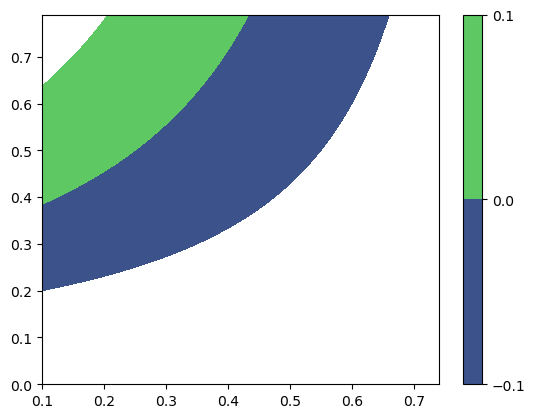

In [34]:
import numpy as np

W = 0.75

chi = np.arange(0.1,W-0.005,0.01)
alpha = np.arange(0, 0.8, 0.01)
 

CHI, ALPHA = np.meshgrid(chi, alpha)

f = W - (1+CHI*ALPHA)/(1+ALPHA)

plt.contourf(CHI, ALPHA, f, levels=[-0.1, 0, 0.1])
plt.colorbar()


# plt.plot(chi, (W-1)/(chi-W))


plt.show()

### set global parameters

In [4]:
## what height is entrained air from?
entrainment_levels = slice(700, 1000)    # m

## what is the reference layer to compute mixed layer AVERAGED quantities?
mixed_avg_levels   = slice(200, 500)

#### load profiles

In [9]:
min_hgt = 40.

level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"
ds_eureca = xr.open_dataset(level2_path)
ds_eureca_bco = ds_eureca.where(((ds_eureca["platform"] == 1)&(ds_eureca["ascent_flag"]==1)&(ds_eureca.alt>min_hgt)), drop=True)
## renaming for common ground
ds_eureca_bco = ds_eureca_bco.swap_dims({"sounding": "launch_time"})
ds_eureca_bco = ds_eureca_bco.rename({"alt":"height"})


ds_orcestra = xr.open_dataset("ipfs://bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4", engine="zarr")
ds_orcestra
ds_orcestra_bco = ds_orcestra.where(((ds_orcestra["platform"] == "BCO")&(ds_orcestra["ascent_flag"]==0)&(ds_orcestra.height>min_hgt)), drop=True)


In [10]:
## campaign-mean profiles
rh_eu = ds_eureca_bco.rh.mean(dim="launch_time")
wind_eu = ds_eureca_bco.wspd.mean(dim="launch_time")
temp_eu = ds_eureca_bco.ta.mean(dim="launch_time")
q_eu = ds_eureca_bco.q.mean(dim="launch_time")

rh_or = ds_orcestra_bco.rh.mean(dim="launch_time")
wind_or = ds_orcestra_bco.wspd.mean(dim="launch_time")
temp_or = ds_orcestra_bco.ta.mean(dim="launch_time")
q_or = ds_orcestra_bco.q.mean(dim="launch_time")


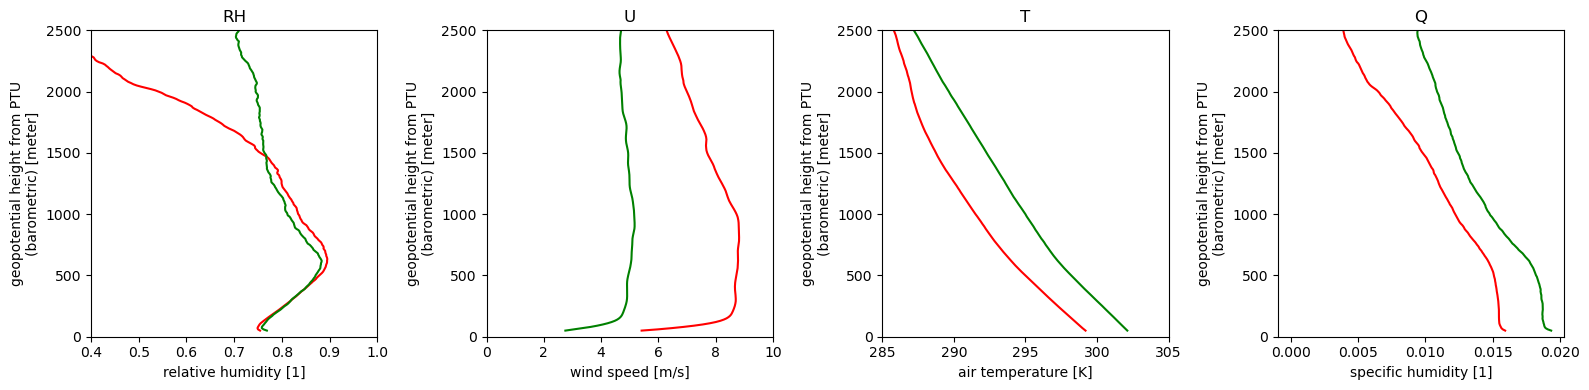

In [11]:
fig, ax = plt.subplots(1,4, figsize=(16,4))

rh_eu.plot.line(ax=ax[0], y="height", color="red")
rh_or.plot.line(ax=ax[0], y="height", color="green")
ax[0].set_title("RH")
ax[0].set_xlim(0.4, 1)

wind_eu.plot.line(ax=ax[1], y="height", color="red")
wind_or.plot.line(ax=ax[1], y="height", color="green")
ax[1].set_title("U")
ax[1].set_xlim(0, 10)


temp_eu.plot.line(ax=ax[2], y="height", color="red")
temp_or.plot.line(ax=ax[2], y="height", color="green")
ax[2].set_title("T")
ax[2].set_xlim(285, 305)


q_eu.plot.line(ax=ax[3], y="height", color="red")
q_or.plot.line(ax=ax[3], y="height", color="green")
ax[3].set_title("Q")
# ax[2].set_xlim(285, 305)



for x in ax:
    x.set_ylim(0,2.5e3)


plt.tight_layout()


In [12]:
## load campaign-mean SST data
ingr_eu = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/EUREC4A_IngrFlux.nc")
sst_eu = ingr_eu.sst.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

ingr_or = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/ORCESTRA_IngrFlux.nc")
sst_or = ingr_or.sst.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

In [13]:
## compute mean q_sfc
from meteo import qsea

sst_local = ingr_eu.sst.sel(cell=[17,24,31,18,25,32, 19,26,33])
q_sfc_eu = qsea(sst_local-273.15, 1013.)
q_sfc_eu = np.mean(q_sfc_eu)

sst_local = ingr_or.sst.sel(cell=[17,24,31,18,25,32, 19,26,33])
q_sfc_or = qsea(sst_local-273.15, 1013.)
q_sfc_or = np.mean(q_sfc_or)

#### do U and q_sfc or fluxes compensate ?

In [14]:
fluxes_eu = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/sfcFluxes_EUREC4A.nc")
lhf_eu = fluxes_eu.lhf.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

fuxes_or = xr.open_dataset("/work/mh1498/m301248/TCO_data/fluxes_data/sfcFluxes_ORCESTRA.nc")
lhf_or = fuxes_or.lhf.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

In [15]:
print(f"Uq EU = {(wind_eu.isel(height=0)*q_sfc_eu):.2f} ; Uq OR = {(wind_or.isel(height=0)*q_sfc_or):.2f}")
print(f"LHF ERA5 EU = {lhf_eu.values:.2f}  ;  LHF ERA5 EU = {lhf_or.values:.2f}")
print("check how the drag coefficients change!")

Uq EU = 119.22 ; Uq OR = 71.95
LHF ERA5 EU = 171.35  ;  LHF ERA5 EU = 134.73
check how the drag coefficients change!


In [16]:
import coare35vn

## ATTENTION: here output only [hsb,hlb, rhoa, Ch,Ce]

u = wind_eu.isel(height=0)
t = temp_eu.isel(height=0)
rh = rh_eu.isel(height=0)
ts = sst_eu
P = 1013.
Rs = ingr_eu.sw_global.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])
Rl = ingr_eu.lw_diff.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

output_eu = coare35vn.coare35vn(u=u.values,
                             t=t.values-273.15,
                             rh=100*rh.values,
                             ts=ts.values-273.15,
                             P=P,
                             Rs=Rs.values,
                             Rl=Rl.values, 
                             zu=50, zt=50, zq=50, lat=13, zi=600, rain=None, cp=None, sigH=None, jcool=1)




u = wind_or.isel(height=0)
t = temp_or.isel(height=0)
rh = rh_or.isel(height=0)
ts = sst_or
P = 1013.
Rs = ingr_or.sw_global.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])
Rl = ingr_or.lw_diff.sel(cell=[17,24,31,18,25,32, 19,26,33]).mean(dim=["cell", "time"])

output_or = coare35vn.coare35vn(u=u.values,
                             t=t.values-273.15,
                             rh=100*rh.values,
                             ts=ts.values-273.15,
                             P=P,
                             Rs=Rs.values,
                             Rl=Rl.values, 
                             zu=50, zt=50, zq=50, lat=13, zi=600, rain=None, cp=None, sigH=None, jcool=1)


/work/mh1498/m301248/TCO_data/COARE-algorithm/Python/COARE3.5/meteo.py:156: RuntimeWarning: invalid value encountered in power
  psi = -((1 + 0.6667*zet)**1.5 + 0.6667*(zet - 14.28)*exp(-dzet) + 8.525)


In [17]:
rho_eu, Ch_eu, Ce_eu = output_eu[0,2], output_eu[0,3] , output_eu[0,4]
rho_or, Ch_or, Ce_or = output_or[0,2], output_or[0,3] , output_or[0,4]

lhf_eu_rec, lhf_or_rec = output_eu[0,1], output_or[0,1]

In [ ]:
print(f"Uq EU = {(wind_eu.isel(height=0)*q_sfc_eu):.2f} ; Uq OR = {(wind_or.isel(height=0)*q_sfc_or):.2f}")
print(f"rho Ce Uq EU = {(rho_eu*Ce_eu*wind_eu.isel(height=0)*q_sfc_eu):.2f} ; rho Ce Uq OR = {(rho_or*Ce_or*wind_or.isel(height=0)*q_sfc_or):.2f}")

print(f"Ce EU = {(Ce_eu):.5f} ; Ce OR = {(Ce_or):.5f}")


print(f"LHF ERA5 EU = {lhf_eu.values:.2f}  ;  LHF ERA5 EU = {lhf_or.values:.2f}")
print(f"LHF EU from prof = {lhf_eu_rec:.2f}  ;  LHF ERA5 EU = {lhf_or_rec:.2f}")


Uq EU = 119.22 ; Uq OR = 71.95
rho Ce Uq EU = 0.16 ; rho Ce Uq OR = 0.11
Ce EU = 0.00113 ; Ce OR = 0.00134
LHF ERA5 EU = 171.35  ;  LHF ERA5 EU = 134.73
LHF EU from prof = 102.70  ;  LHF ERA5 EU = 69.45


In [19]:
import pandas as pd
from IPython.display import display, HTML

data = [
    [r"Uq (m/s g/kg)", f"{(wind_eu.isel(height=0) * q_sfc_eu):.2f}", f"{(wind_or.isel(height=0) * q_sfc_or):.2f}"],
    ["ρCeUq (g / m²s)", f"{(rho_eu * Ce_eu * wind_eu.isel(height=0) * q_sfc_eu):.2f}", f"{(rho_or * Ce_or * wind_or.isel(height=0) * q_sfc_or):.2f}"],
    ["Ce", f"{Ce_eu:.5f}", f"{Ce_or:.5f}"],
    ["Ch", f"{Ch_eu:.5f}", f"{Ch_or:.5f}"],
    ["LHF ERA5 (W/m²)", f"{lhf_eu:.2f}", f"{lhf_or:.2f}"],
    ["LHF from Prof (50m) (W/m²)", f"{lhf_eu_rec:.2f}", f"{lhf_or_rec:.2f}"],
]

# Create DataFrame
df = pd.DataFrame(data, columns=["Quantity", "EU", "OR"])

display(HTML(df.to_html(index=False, table_id="summary-table")))

Quantity,EU,OR
Uq (m/s g/kg),119.22,71.95
ρCeUq (g / m²s),0.16,0.11
Ce,0.00113,0.00134
Ch,0.00113,0.00134
LHF ERA5 (W/m²),171.35,134.73
LHF from Prof (50m) (W/m²),102.70,69.45


In [ ]:
## LET'S DOUBLE Ce
# Ce_eu = 2*Ce_eu
# Ce_or = 2*Ce_or

In [21]:
q_out_eu = q_eu.sel(height=entrainment_levels).values*1e3
q_out_or = q_or.sel(height=entrainment_levels).values*1e3

def E(q_out, q_sfc, Vs, W=0.75):
    E = ((W-1)*Vs)/((q_out/q_sfc)-W)
    return E

Vs_lhf_eu = (rho_eu * Ce_eu * wind_eu.isel(height=0)).values
Vs_lhf_or = (rho_or * Ce_or * wind_or.isel(height=0)).values

## compute a series of E values
E_values_eu = E(q_out_eu, q_sfc_eu, Vs_lhf_eu)
E_values_or = E(q_out_or, q_sfc_or, Vs_lhf_or)

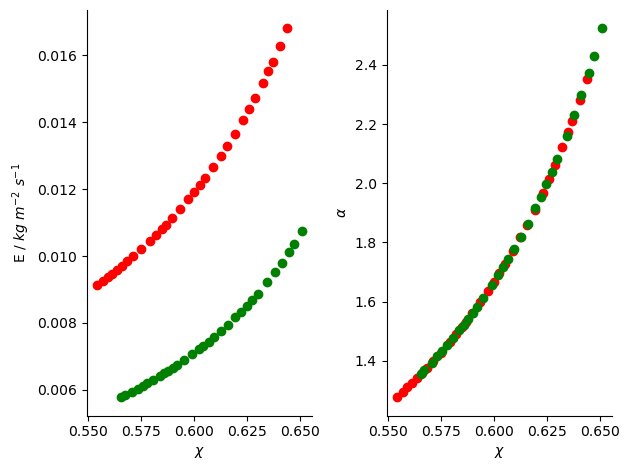

In [22]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(q_out_eu/q_sfc_eu, E_values_eu, color="red", label="EUREC4A")
ax[0].scatter(q_out_or/q_sfc_or, E_values_or, color="green", label="ORCESTRA")

# ax[0].set_xlabel(r"$q_\mathrm{out}$ / $g~kg^{-1}$")
ax[0].set_xlabel(r"$\chi$")
ax[0].set_ylabel(r"E / $kg~m^{-2}~s^{-1}$")


ax[1].scatter(q_out_eu/q_sfc_eu, E_values_eu/Vs_lhf_eu, color="red", label="EUREC4A")
ax[1].scatter(q_out_or/q_sfc_or, E_values_or/Vs_lhf_or, color="green", label="ORCESTRA")

ax[1].set_xlabel(r"$\chi$")
ax[1].set_ylabel(r"$\alpha$")


for x in ax:
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)



plt.tight_layout()
plt.show()

#### use E values in the bulk framework for potential temperature

the temperature equation in the bulk formulation takes the form
$$\theta_\mathrm{bl} = \frac{V_\mathrm{sfc} ~SST + E\theta_\mathrm{out}}{V_\mathrm{sfc}+E} + Radiation$$

In [ ]:
## reduce Ch to half
# Ch_eu = 0.5*Ch_eu
# Ch_or = 0.5*Ch_or

In [26]:
## compute predicted theta and compare with average theta and its variability
theta_eu = ds_eureca_bco.theta.mean(dim="launch_time")
theta_or = ds_orcestra_bco.theta.mean(dim="launch_time")

theta_out_eu = theta_eu.sel(height=entrainment_levels).values
theta_out_or = theta_or.sel(height=entrainment_levels).values

## use Vs for sensible heat exchange
Vs_shf_eu = (rho_eu * Ch_eu * wind_eu.isel(height=0)).values
Vs_shf_or = (rho_or * Ch_or * wind_or.isel(height=0)).values

theta_pred_eu = (Vs_shf_eu*sst_eu.values + E_values_eu*theta_out_eu) / (Vs_shf_eu+E_values_eu)
theta_pred_or = (Vs_shf_or*sst_or.values + E_values_or*theta_out_or) / (Vs_shf_or+E_values_or)


## actual mixed-layer averaged theta
theta_bl_eu = theta_eu.sel(height=mixed_avg_levels).mean()
th_var_eu   = ds_eureca_bco.theta.sel(height=mixed_avg_levels).mean(dim="height").std(dim="launch_time")

theta_bl_or = theta_or.sel(height=mixed_avg_levels).mean()
th_var_or   = ds_orcestra_bco.theta.sel(height=mixed_avg_levels).mean(dim="height").std(dim="launch_time")


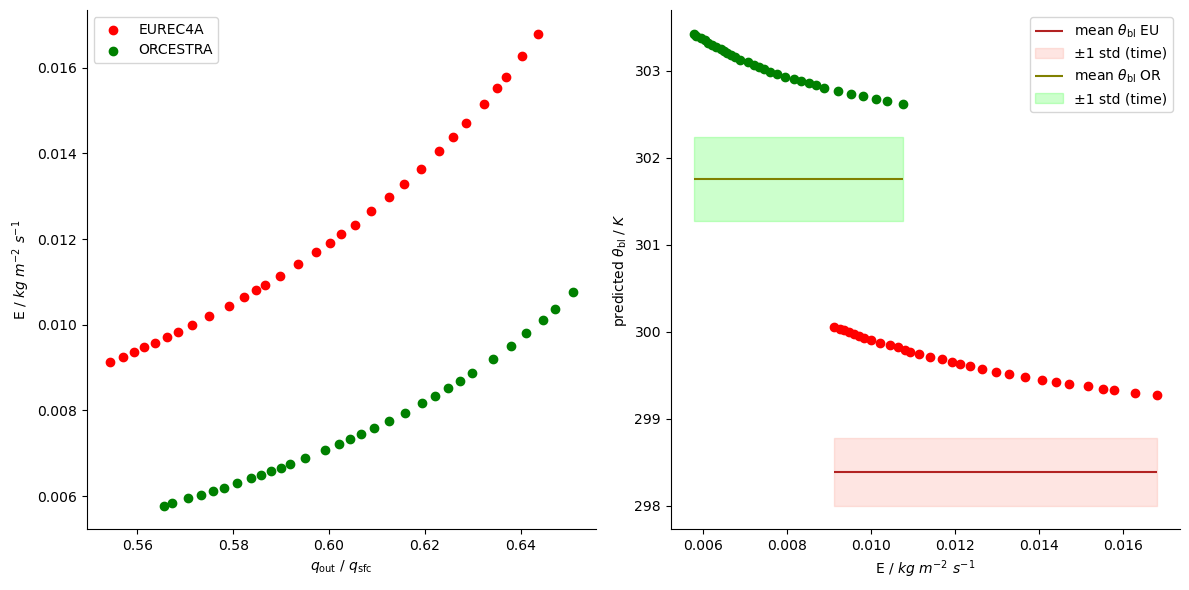

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

#### report E for values of q_out
ax[0].scatter(q_out_eu/q_sfc_eu, E_values_eu, color="red", label="EUREC4A")
ax[0].scatter(q_out_or/q_sfc_or, E_values_or, color="green", label="ORCESTRA")

ax[0].set_xlabel(r"$q_\mathrm{out}$ / $q_\mathrm{sfc}$")
# ax[0].set_xlabel(r"$\chi$")
ax[0].set_ylabel(r"E / $kg~m^{-2}~s^{-1}$")
ax[0].legend()






#### compare predicted theta with actual theta

ax[1].scatter(E_values_eu, theta_pred_eu, color="red")
ax[1].scatter(E_values_or, theta_pred_or, color="green")

ax[1].hlines(theta_bl_eu, xmin=np.min(E_values_eu), xmax=np.max(E_values_eu), color="firebrick", label=r"mean $\theta_\mathrm{bl}$ EU")
ax[1].fill_between(
    [np.min(E_values_eu), np.max(E_values_eu)],
    (theta_bl_eu - th_var_eu) ,
    (theta_bl_eu + th_var_eu) ,
    color="salmon",
    alpha=0.2,
    label='±1 std (time)'
)



ax[1].hlines(theta_bl_or, xmin=np.min(E_values_or), xmax=np.max(E_values_or), color="olive", label=r"mean $\theta_\mathrm{bl}$ OR")
ax[1].fill_between(
    [np.min(E_values_or), np.max(E_values_or)],
    (theta_bl_or - th_var_or) ,
    (theta_bl_or + th_var_or) ,
    color="lime",
    alpha=0.2,
    label='±1 std (time)'
)



ax[1].set_xlabel(r"E / $kg~m^{-2}~s^{-1}$")
ax[1].set_ylabel(r"predicted $\theta_\mathrm{bl}$ / $K$")
ax[1].legend()

for x in ax:
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)



plt.tight_layout()
plt.show()

##### include radiation: Yokoi and Katsumata 2022

In [28]:
eps = 0.14
oc_abs = 0.97        ## ocean absorptivity == emissivity
stefan = 5.67*1e-8
eta = 0.02
oc_alb = 0.055

cp = 1005 # j / kg K



def rad_terms(sw_in, lw_in, sst):
    return (eps/(1-eps))*lw_in +eps*oc_abs*stefan*(sst)**4 + ((eta//(1-eta)) + eta*(1-oc_alb))*sw_in

non_thBL_terms_eu = rad_terms(ingr_eu.sw_global.sel(cell=0).mean(dim="time").values, ingr_eu.lw_diff.sel(cell=0).mean(dim="time").values, sst_eu.values)
non_thBL_terms_or = rad_terms(ingr_or.sw_global.sel(cell=0).mean(dim="time").values, ingr_or.lw_diff.sel(cell=0).mean(dim="time").values, sst_or.values)

In [30]:
theta_predRad_eu = np.zeros_like(E_values_eu)
theta_predRad_or = np.zeros_like(E_values_or)

## EUREC4A DATA

for i, E in enumerate(E_values_eu):
    # Define the coefficients of the quartic: a*x^4 + b*x^3 + c*x^2 + d*x + e = 0
    coeffs = [
        -((2 - eps) / (1 - eps)) * eps * stefan,  # a (x^4)
        0,                                        # b (x^3)
        0,                                        # c (x^2)
        -(1.*cp*Vs_shf_eu + 0.8*cp*E),                             # d (x^1)
        1.*cp*Vs_shf_eu * sst_eu.values + 0.8*cp*E * theta_out_eu[i] + non_thBL_terms_eu  # e (constant)
    ]
    
    # Solve the polynomial
    roots = np.roots(coeffs)
    
    # Filter only the fully real roots (no imaginary part)
    real_roots = roots[np.isreal(roots)]
    real_roots = np.real(real_roots) 
    
    # Now filter for physically meaningful (positive) roots
    positive_real_roots = real_roots[real_roots > 0]
    
    if len(positive_real_roots) > 0:
        theta_predRad_eu[i] = np.max(positive_real_roots)



## ORCESTRA DATA

for i, E in enumerate(E_values_or):
    # Define the coefficients of the quartic: a*x^4 + b*x^3 + c*x^2 + d*x + e = 0
    coeffs = [
        -((2 - eps) / (1 - eps)) * eps * stefan,  # a (x^4)
        0,                                        # b (x^3)
        0,                                        # c (x^2)
        -(1.*cp*Vs_shf_or + 0.8*cp*E),                             # d (x^1)
        1.*cp*Vs_shf_or * sst_or.values + 0.8*cp*E * theta_out_or[i] + non_thBL_terms_or  # e (constant)
    ]
    
    # Solve the polynomial
    roots = np.roots(coeffs)
    
    # Filter only the fully real roots (no imaginary part)
    real_roots = roots[np.isreal(roots)]
    real_roots = np.real(real_roots)
    
    # Now filter for physically meaningful (positive) roots
    positive_real_roots = real_roots[real_roots > 0]
    
    if len(positive_real_roots) > 0:
        theta_predRad_or[i] = np.max(positive_real_roots)

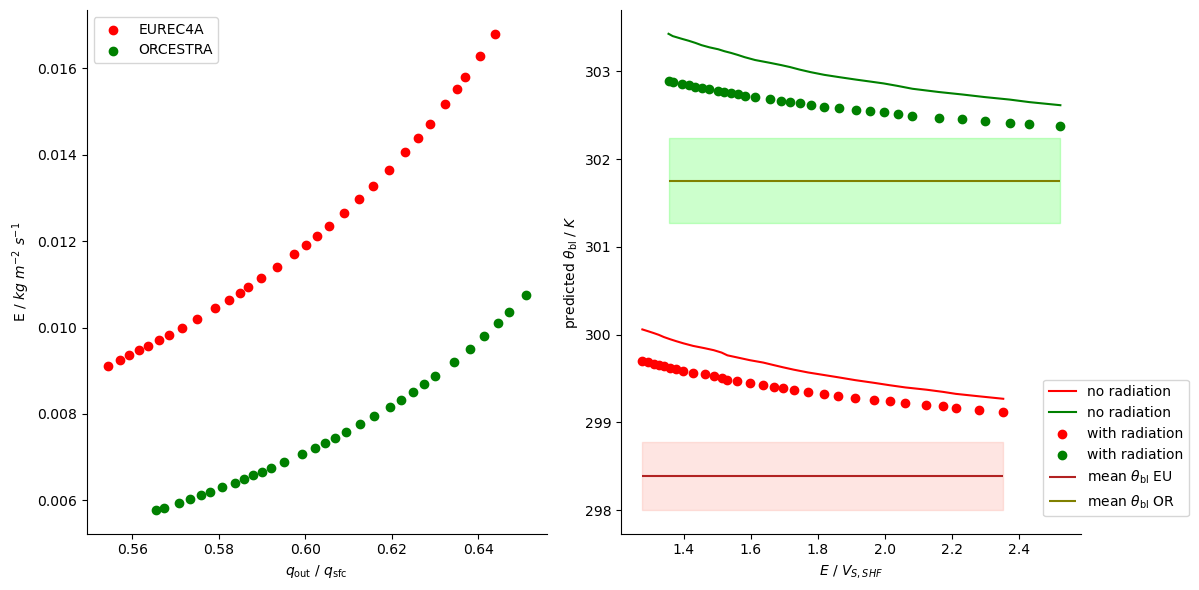

In [31]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

#### report E for values of q_out
ax[0].scatter(q_out_eu/q_sfc_eu, E_values_eu, color="red", label="EUREC4A")
ax[0].scatter(q_out_or/q_sfc_or, E_values_or, color="green", label="ORCESTRA")

ax[0].set_xlabel(r"$q_\mathrm{out}$ / $q_\mathrm{sfc}$")
# ax[0].set_xlabel(r"$\chi$")
ax[0].set_ylabel(r"E / $kg~m^{-2}~s^{-1}$")
ax[0].legend()






#### compare predicted theta with actual theta
ax[1].plot(E_values_eu/Vs_shf_eu, theta_pred_eu, color="red", label="no radiation")
ax[1].plot(E_values_or/Vs_shf_or, theta_pred_or, color="green", label="no radiation")

ax[1].scatter(E_values_eu/Vs_shf_eu, theta_predRad_eu, color="red", label="with radiation")
ax[1].scatter(E_values_or/Vs_shf_or, theta_predRad_or, color="green", label="with radiation")

ax[1].hlines(theta_bl_eu, xmin=np.min(E_values_eu/Vs_shf_eu), xmax=np.max(E_values_eu/Vs_shf_eu), color="firebrick", label=r"mean $\theta_\mathrm{bl}$ EU")
ax[1].fill_between(
    [np.min(E_values_eu/Vs_shf_eu), np.max(E_values_eu/Vs_shf_eu)],
    (theta_bl_eu - th_var_eu) ,
    (theta_bl_eu + th_var_eu) ,
    color="salmon",
    alpha=0.2
)



ax[1].hlines(theta_bl_or, xmin=np.min(E_values_or/Vs_shf_or), xmax=np.max(E_values_or/Vs_shf_or), color="olive", label=r"mean $\theta_\mathrm{bl}$ OR")
ax[1].fill_between(
    [np.min(E_values_or/Vs_shf_or), np.max(E_values_or/Vs_shf_or)],
    (theta_bl_or - th_var_or) ,
    (theta_bl_or + th_var_or) ,
    color="lime",
    alpha=0.2
)



ax[1].set_xlabel(r"$E$ / $V_{S,SHF}$ ") #/ $kg~m^{-2}~s^{-1}$")
ax[1].set_ylabel(r"predicted $\theta_\mathrm{bl}$ / $K$")
ax[1].legend(loc="lower right", bbox_to_anchor=(1.25,0.02))

for x in ax:
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)



plt.tight_layout()
plt.show()

#### can we estimate what role advection plays, using differences between each single radiosounding?

In [ ]:

def local_adv(ds, max_hgt):
    heightss = slice(50, max_hgt)
    wspd  = ds.wspd.sel(height=heightss)
    wspd_pair_mean = (wspd + wspd.shift(launch_time=-1)) / 2
    wspd_pair_mean = wspd_pair_mean.isel(launch_time=slice(0, -1)).values

    moist = ds.q.sel(height=heightss)
    th    = ds.theta.sel(height=heightss)

    dt  = (ds.launch_time.diff(dim="launch_time") / np.timedelta64(1,"h"))
    dt = dt.rename("dt")  # give it a name

    dt_hgt = dt.expand_dims(height=wspd.height).transpose("launch_time", "height")

    ## it's actually harder than I was expecting
    ## THIS IS THE TOTAL CHANGE IN TIME
    moist_adv = -wspd_pair_mean*((moist.diff(dim="launch_time")))  / (wspd_pair_mean*dt_hgt)
    th_adv    = -wspd_pair_mean*((th.diff(dim="launch_time")) ) / (wspd_pair_mean*dt_hgt)

    return moist_adv, th_adv




q_adv_eu, th_adv_eu = local_adv(ds_eureca_bco, max_hgt=500)
q_adv_or, th_adv_or = local_adv(ds_orcestra_bco, max_hgt=500)

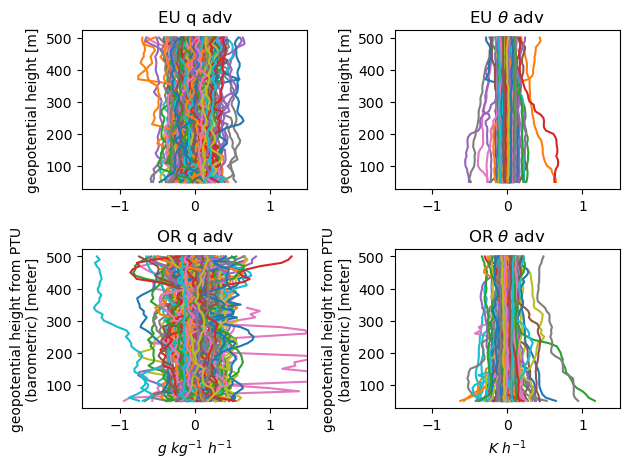

In [49]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()

(q_adv_eu*1e3).plot.line(ax=ax[0], y="height", add_legend=False)
(q_adv_or*1e3).plot.line(ax=ax[2], y="height", add_legend=False)

ax[0].set_title("EU q adv")
ax[0].set_xlabel("")
ax[2].set_title("OR q adv")
ax[2].set_xlabel(r"$g~kg^{-1}~h^{-1}$")

for x in [ax[0], ax[2]]:
    x.set_xlim(-1.5, 1.5)




th_adv_eu.plot.line(ax=ax[1], y="height", add_legend=False)
th_adv_or.plot.line(ax=ax[3], y="height", add_legend=False)

ax[1].set_title(r"EU $\theta$ adv")
ax[3].set_title(r"OR $\theta$ adv")
ax[1].set_xlabel("")
ax[3].set_xlabel(r"$K~h^{-1}$")

for x in [ax[1], ax[3]]:
    x.set_xlim(-1.5, 1.5)

plt.tight_layout()
plt.show()